In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from typing import List, TypedDict, Annotated
from dotenv import load_dotenv


In [2]:
load_dotenv()
llm = ChatOpenAI(model="gpt-4.1-nano")

In [3]:
# state definition

# base message is the parent of all message types, hence it is used to add any type of messages
# add_messages is optimized version of operator.add to add messages (while using reducer function)
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [4]:
def chat_node(state: ChatState):

    # take user query from state
    messages = state['messages']

    # call llm to get response
    response = llm.invoke(messages)

    # add response to state
    return {'messages': [response]}

In [5]:
# define checkpointer for memory
checkpointer = MemorySaver()

# define state graph
graph = StateGraph(ChatState)

# add nodes to the graph
graph.add_node('chat_node', chat_node)

# add edges to the graph
graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

# compile the graph
workflow = graph.compile(checkpointer=checkpointer)

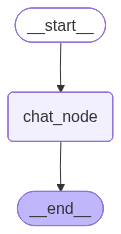

In [6]:
workflow

We built a basic skleton of the chat bot, now, we will build the coversational part

In [8]:
# thread id is used to identify the thread (it can be a conversation id, user id, etc.)
thread_id = '1'

while True:
    user_message = input("input your question here...")
    print('User:', user_message)
    if user_message.strip().lower() in ['exit', 'bye', 'quit']:
        break

    initial_state = {
        'messages': [HumanMessage(content=user_message)]
    }
    config = {'configurable': {'thread_id': thread_id}}
    response = workflow.invoke(initial_state, config=config)
   
    print('AI:', response['messages'][-1].content)
    print(len(response['messages']))

User: Hi i am srini
AI: Hello Srini! How can I assist you today?
2
User: what is my name ?
AI: Your name is Srini. How can I help you today?
4
User: can you tell the capital of california
AI: The capital of California is Sacramento.
6
User: exit


If we now observe, the chat is being saved with the help of checkpointer
- it uses the thread_id to identify, which thread is being used
- it also helps against which thread_id should we save the messages.

In [11]:
# we can view the memory

workflow.get_state(config=config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi i am srini', additional_kwargs={}, response_metadata={}, id='8d36fb29-de64-447c-b011-c95b733ad7ab'), AIMessage(content='Hello Srini! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 12, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_1a97b5aa6c', 'id': 'chatcmpl-CcCdny9LyOeWh20T3ggpTMkrmufVZ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--72d0227f-6199-4f3c-8028-a13711693115-0', usage_metadata={'input_tokens': 12, 'output_tokens': 11, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}